In [1]:
from __future__ import division, absolute_import, print_function
import numpy as np
import json
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.tuning import TrainValidationSplit, CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.sql.types import *
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as fp
import sys
import time
import pandas as pd
import os
%matplotlib inline

## Data

In [2]:
os.system('cat {0} | hadoop fs -put -f - {1}'.format('./example.csv', './example'))

0

In [3]:
df = spark.read.format("csv").option("header", "true").load("./example")

In [4]:
df = df.select('Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Survived')\
       .fillna('unknown', subset=['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin'])\
       .fillna('-1', subset='Age')\
       .fillna('-1.0', subset='Fare')

In [5]:
df = df.withColumn('Age', F.col('Age').cast(IntegerType()))\
       .withColumn('Fare', F.col('Fare').cast(DoubleType()))\
       .withColumn('Survived', F.col('Survived').cast(IntegerType()))

In [6]:
@F.udf
def head(x):
    return x[0]

In [7]:
df = df.withColumn('Cabin_init', head('Cabin')).drop('Cabin')

In [8]:
df.show()
df.printSchema()

+------+------+---+-----+-----+-------+--------+--------+----------+
|Pclass|   Sex|Age|SibSp|Parch|   Fare|Embarked|Survived|Cabin_init|
+------+------+---+-----+-----+-------+--------+--------+----------+
|     3|  male| 22|    1|    0|   7.25|       S|       0|         u|
|     1|female| 38|    1|    0|71.2833|       C|       1|         C|
|     3|female| 26|    0|    0|  7.925|       S|       1|         u|
|     1|female| 35|    1|    0|   53.1|       S|       1|         C|
|     3|  male| 35|    0|    0|   8.05|       S|       0|         u|
|     3|  male| -1|    0|    0| 8.4583|       Q|       0|         u|
|     1|  male| 54|    0|    0|51.8625|       S|       0|         E|
|     3|  male|  2|    3|    1| 21.075|       S|       0|         u|
|     3|female| 27|    0|    2|11.1333|       S|       1|         u|
|     2|female| 14|    1|    0|30.0708|       C|       1|         u|
|     3|female|  4|    1|    1|   16.7|       S|       1|         G|
|     1|female| 58|    0|    0|  2

## Training

In [9]:
# String Indexing for categorical features
cat_cols = ('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init')
indexers = [StringIndexer(inputCol=coln, outputCol=coln+"_idx") for coln in cat_cols]
# One-hot encoding for categorical features
encoders = [OneHotEncoder(inputCol=coln+"_idx", outputCol=coln+"_oh") for coln in cat_cols]
pipeline = Pipeline(stages=(indexers + encoders))
preprocessor = pipeline.fit(df)
df = preprocessor.transform(df).drop(*[coln+"_idx" for coln in cat_cols])

In [10]:
assembler = VectorAssembler(inputCols = ['Age', 'Fare'] + [coln+"_oh" for coln in cat_cols], outputCol = "features")
rf = GBTClassifier(labelCol="Survived", featuresCol="features")
p = Pipeline(stages=[rf])
model = p.fit(assembler.transform(df))

## Evaluation

In [11]:
import sys
sys.path.append('..')

### Discrete Precision/Recall Plot (Binary-Classification only)

In [12]:
from pytalite_spark.interpretation import decile_plot

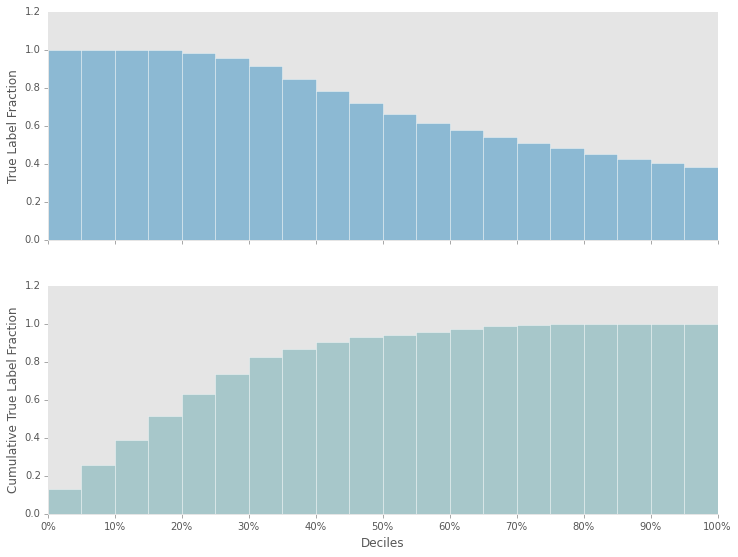

In [13]:
decile_plot(df, 'Survived', model, model_input_col='features',
            columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'), num_deciles=20)

### Probability Density Plot (Binary-Classification only)

In [14]:
from pytalite_spark.interpretation import density_plot

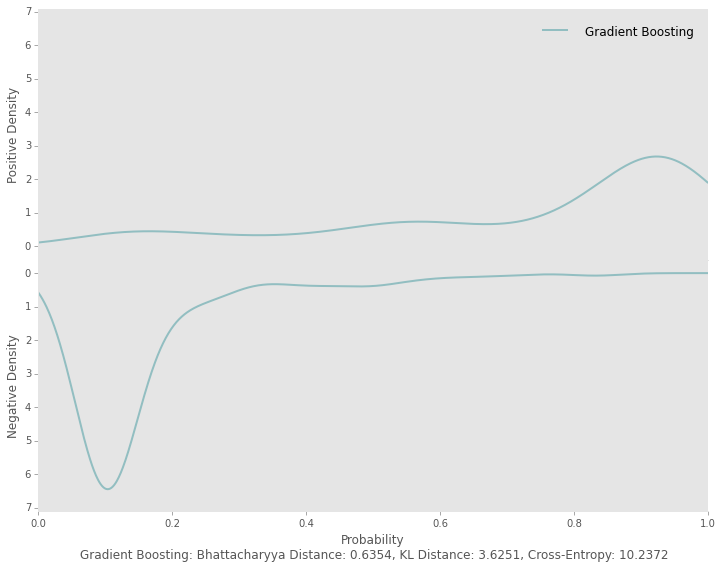

In [15]:
density_plot(df, 'Survived', [model], model_names=['Gradient Boosting'], model_input_col='features',
             columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))

### Feature Importance Plot (Binary-Classification only)

In [16]:
from pytalite_spark.interpretation import feature_importance_plot

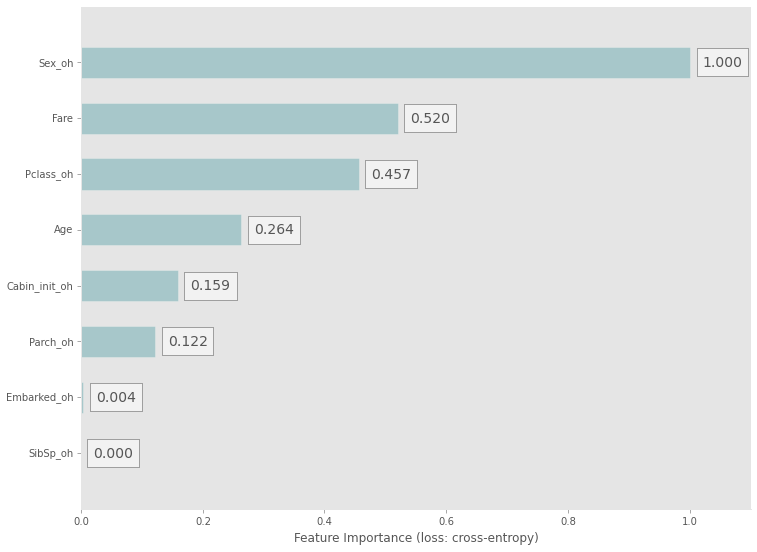

In [19]:
feature_importance_plot(df, 'Survived', model, model_input_col='features',
                        columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))

### Feature Correlation Plot (Binary-Classification only)

In [12]:
from pytalite_spark.interpretation import feature_correlation_plot

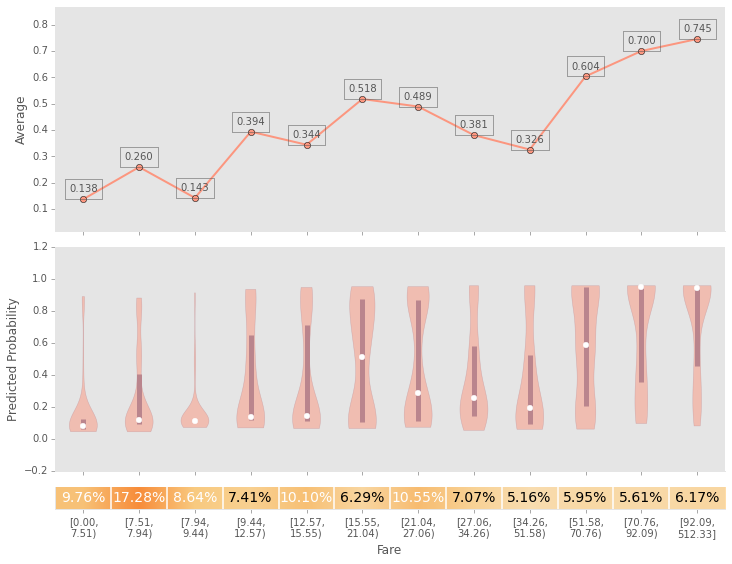

In [21]:
feature_correlation_plot(df, 'Survived', model, 'Fare', model_input_col='features',
                         columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))

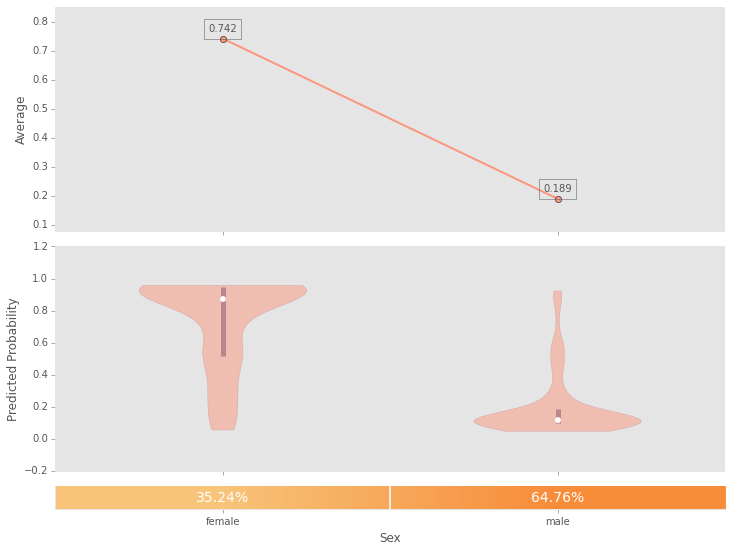

In [13]:
feature_correlation_plot(df, 'Survived', model, 'Sex', model_input_col='features',
                         columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))

### Partial Dependence Plot (Binary-Classification / Regression)

In [12]:
from pytalite_spark.interpretation import partial_dependence_plot

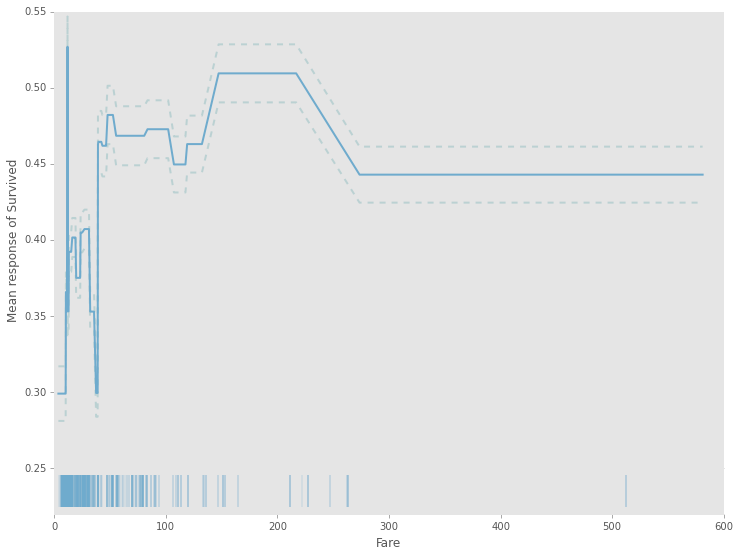

In [13]:
partial_dependence_plot(df, 'Survived', model, 'Fare', model_input_col='features', model_type='classification',
                            columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))

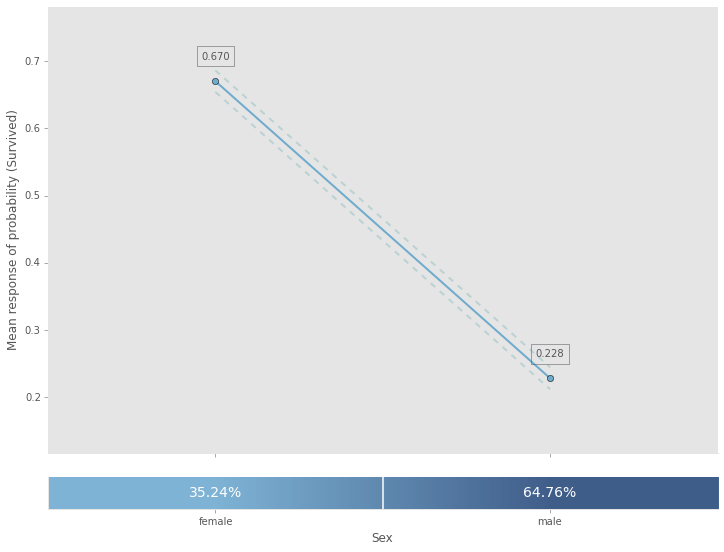

In [14]:
# One-hot
partial_dependence_plot(df, 'Survived', model, ('Sex_oh', 'Sex'), model_input_col='features', model_type='classification',
                            columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))

### Accumulated Local Effect Plot (Binary-Classification / Regression, numerical feature)

In [15]:
from pytalite_spark.interpretation import feature_ale_plot

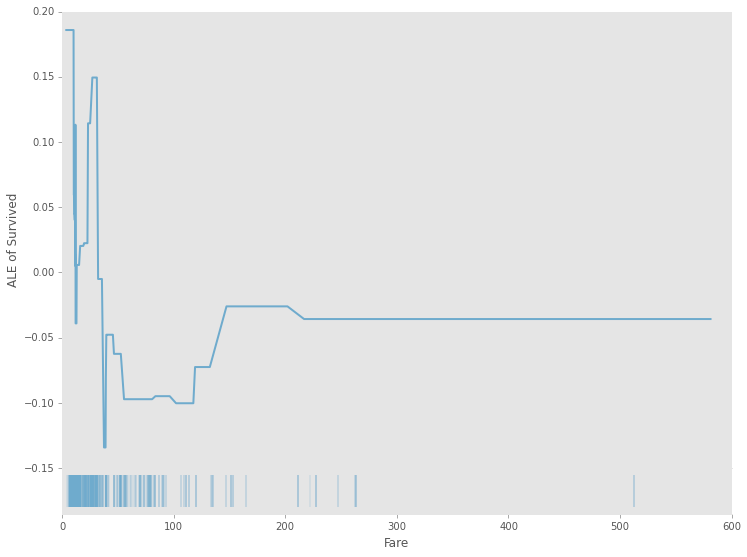

In [16]:
feature_ale_plot(df, 'Survived', model, 'Fare', model_input_col='features', model_type='classification',
                 columns_to_exclude=('Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_init'))